In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diff_skewed_gaussian_rasterization import GaussianRasterizer, GaussianRasterizationSettings
from PIL import Image
import ipywidgets as widgets
from ipywidgets import interactive, fixed, FloatSlider, IntSlider, ColorPicker
from IPython.display import display, clear_output

# Comprobamos si hay GPU disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Usando dispositivo: cuda:0


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from diff_skewed_gaussian_rasterization import GaussianRasterizer, GaussianRasterizationSettings
from PIL import Image
import ipywidgets as widgets
from ipywidgets import interactive, fixed, FloatSlider, IntSlider, ColorPicker
from IPython.display import display, clear_output

# Comprobamos si hay GPU disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Configuración para la renderización
def create_raster_settings(camera_x, camera_y, camera_z, 
                          look_x, look_y, look_z,
                          up_x, up_y, up_z,
                          fov_degrees, bg_color,
                          scale_modifier, image_size):
    
    # Convertir FOV de grados a radianes usando torch
    fov_rad = torch.tensor(np.radians(fov_degrees), dtype=torch.float32)
    tan_fov = torch.tan(fov_rad / 2)
    
    # Configurar la cámara
    eye = np.array([camera_x, camera_y, camera_z])
    target = np.array([look_x, look_y, look_z])
    up = np.array([up_x, up_y, up_z])
    
    # Normalizar el vector up
    up = up / np.linalg.norm(up)
    
    # Crear matrices de vista y proyección
    view_matrix = get_camera_matrix(eye, target, up).to(device)
    proj_matrix = get_projection_matrix(fov_rad, fov_rad).to(device)
    campos = torch.tensor(eye, dtype=torch.float32, device=device)
    
    
    # Color de fondo
    bg = torch.tensor(bg_color, dtype=torch.float32, device=device)
    
    # Crear los parámetros de configuración del rasterizador
    raster_settings = GaussianRasterizationSettings(
        image_height=image_size,
        image_width=image_size,
        tanfovx=tan_fov,
        tanfovy=tan_fov,
        bg=bg,
        scale_modifier=scale_modifier,
        viewmatrix=view_matrix,
        projmatrix=proj_matrix,
        sh_degree=0,
        campos=campos,
        prefiltered=False,
        debug=True,  # Activar modo debug para ver más información
    )
    
    return raster_settings, eye, target, up

def get_camera_matrix(eye, target, up):
    """
    Crea una matriz de vista World2View usando el método correcto
    """
    eye = torch.tensor(eye, dtype=torch.float32)
    target = torch.tensor(target, dtype=torch.float32)
    up = torch.tensor(up, dtype=torch.float32)
    
    z_axis = eye - target
    z_axis = z_axis / torch.norm(z_axis)
    
    x_axis = torch.cross(up, z_axis)
    x_axis = x_axis / torch.norm(x_axis)
    
    y_axis = torch.cross(z_axis, x_axis)
    y_axis = y_axis / torch.norm(y_axis)
    
    R = torch.stack([x_axis, y_axis, z_axis], dim=1)
    t = -torch.matmul(R, eye)
    
    view_matrix = torch.eye(4, dtype=torch.float32)
    view_matrix[:3, :3] = R
    view_matrix[:3, 3] = t
    
    return view_matrix
    
    return view_matrix
def get_projection_matrix(fovx, fovy, near=0.1, far=1000.0):
    """
    Crea una matriz de proyección perspectiva usando el método correcto
    basado en near/far planes y FOV
    """
    # Convertir los valores de entrada a tensores de PyTorch
    fovx = torch.tensor(fovx, dtype=torch.float32)
    fovy = torch.tensor(fovy, dtype=torch.float32)
    
    tanHalfFovY = torch.tan(fovy / 2)
    tanHalfFovX = torch.tan(fovx / 2)
    
    top = tanHalfFovY * near
    bottom = -top
    right = tanHalfFovX * near
    left = -right
    
    P = torch.zeros(4, 4, dtype=torch.float32)
    
    P[0, 0] = 2.0 * near / (right - left)
    P[1, 1] = 2.0 * near / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = far / (far - near)
    P[2, 3] = -(far * near) / (far - near)
    P[3, 2] = 1.0
    
    return P

# Calcular las posiciones 2D proyectadas con corrección de profundidad
def project_points(points, view_matrix, proj_matrix):
    """Proyecta puntos 3D a coordenadas 2D"""
    # Convertir a coordenadas homogéneas
    homogeneous = torch.ones((points.shape[0], 4), device=points.device)
    homogeneous[:, :3] = points
    
    # Aplicar transformación view-projection
    view_proj = torch.matmul(proj_matrix, view_matrix)
    projected = torch.matmul(homogeneous, view_proj.T)
    
    # Dividir por w para obtener coordenadas NDC
    # Usar un valor pequeño para evitar división por cero
    projected_w = projected[:, 3:4].clone()
    projected_w[projected_w.abs() < 1e-6] = 1e-6  # Evitar división por cero
    ndc = projected[:, :3] / projected_w
    
    # Coordenadas de pantalla (solo x,y)
    screen_pos = ndc[:, :2]
    
    return screen_pos

# Crear gaussianas con valores predeterminados que aseguran visibilidad
def create_gaussians(pos_x, pos_y, pos_z, scale_x, scale_y, scale_z, rot_x, rot_y, rot_z, rot_w, opacity, color_r, color_g, color_b,skew_x=0,skew_y=0,skew_z=0):
    # Posición
    means3D = torch.tensor([[pos_x, pos_y, pos_z]], dtype=torch.float32, device=device)
    
    # Escala - Asegurarse de que las escalas sean positivas y no demasiado pequeñas
    scale_x = max(scale_x, 0.05)  # Valor mínimo para garantizar visibilidad
    scale_y = max(scale_y, 0.05)
    scale_z = max(scale_z, 0.05)
    scales = torch.tensor([[scale_x, scale_y, scale_z]], dtype=torch.float32, device=device)
    skew= torch.tensor([[skew_x, skew_y, skew_z]], dtype=torch.float32, device=device)
    # Rotación (representada como un cuaternión)
    rot_length = np.sqrt(rot_x**2 + rot_y**2 + rot_z**2 + rot_w**2)
    if rot_length > 0.001:  # Asegurar que no sea casi cero
        rot_normalized = [rot_x/rot_length, rot_y/rot_length, rot_z/rot_length, rot_w/rot_length]
    else:
        rot_normalized = [0, 0, 0, 1]  # Cuaternión identidad si la longitud es casi 0
    
    rotations = torch.tensor([rot_normalized], dtype=torch.float32, device=device)
    
    # Opacidad - Asegurar que sea visible
    opacity = max(opacity, 0.5)  # Mínimo 0.5 para asegurar visibilidad
    opacities = torch.tensor([[opacity]], dtype=torch.float32, device=device)
    
    # Color - Asegurar que no sea negro (sería invisible en fondo negro)
    if color_r == 0 and color_g == 0 and color_b == 0:
        color_r = 1.0  # Predeterminado a rojo si es negro
    
    colors_precomp = torch.tensor([[color_r, color_g, color_b]], dtype=torch.float32, device=device)
    
    return means3D, scales, skew, rotations, opacities, colors_precomp
# Función para renderizar la escena
def render_scene(
    # Cámara
    camera_x=0.0, camera_y=0.0, camera_z=2.0,
    look_x=0.0, look_y=0.0, look_z=0.0,
    up_x=0.0, up_y=1.0, up_z=0.0,
    fov_degrees=60.0,  # Aumentado el FOV para mejor visualización
    
    # Gaussiana
    pos_x=0.0, pos_y=0.0, pos_z=0.0,
    scale_x=0.3, scale_y=0.3, scale_z=0.3,
    rot_x=0.0, rot_y=0.0, rot_z=0.0, rot_w=1.0,
    skew_x=0.0, skew_y=0.0, skew_z=0.0,
    opacity=1.0,
    
    # Visualización
    color_r=1.0, color_g=0.0, color_b=0.0,
    bg_r=0.0, bg_g=0.0, bg_b=0.0,
    scale_modifier=1.0,
    image_size=256
):
    try:
        # Print para depuración
        print(f"Renderizando con: Gaussiana en ({pos_x}, {pos_y}, {pos_z}), Escala: ({scale_x}, {scale_y}, {scale_z}), Color: ({color_r}, {color_g}, {color_b})")
        
        # Configurar rasterizador
        bg_color = [bg_r, bg_g, bg_b]
        raster_settings, eye, target, up = create_raster_settings(
            camera_x, camera_y, camera_z,
            look_x, look_y, look_z,
            up_x, up_y, up_z, 
            fov_degrees, bg_color, scale_modifier, image_size
        )
        
        # Crear el rasterizador
        rasterizer = GaussianRasterizer(raster_settings)
        
        # Crear gaussianas
        means3D, scales, skew, rotations, opacities, colors_precomp= create_gaussians(
            pos_x, pos_y, pos_z, 
            scale_x, scale_y, scale_z, 
            rot_x, rot_y, rot_z, rot_w, 
            opacity, 
            color_r, color_g, color_b,
            skew_x, skew_y, skew_z
        )
        
        # Proyectar puntos 3D a 2D
        means2D = project_points(means3D, raster_settings.viewmatrix, raster_settings.projmatrix)
        
        # Imprimir valores para depuración
        print(f"means3D: {means3D}")
        print(f"means2D: {means2D}")
        print(f"scales: {scales}")
        print(f"skew: {skew}")
        print(f"opacities: {opacities}")
        print(f"colors_precomp: {colors_precomp}")
        
        # Renderizar la escena
        rendered_image, depth = rasterizer(
            means3D=means3D,
            means2D=means2D,
            opacities=opacities,
            colors_precomp=colors_precomp,
            scales=scales,
            rotations=rotations,
            skews=skew
        )
        
        # Mostrar imagen
        rendered_image_np = rendered_image.detach().cpu().numpy()
        rendered_image_np = np.transpose(rendered_image_np, (1, 2, 0))  # CHW -> HWC
        rendered_image_np = np.clip(rendered_image_np, 0, 1)
        
        # Comprobar la forma de depth antes de intentar visualizarlo
        if depth is not None and depth.ndim > 1:
            depth_np = depth.detach().cpu().numpy()
            
            plt.figure(figsize=(16, 8))
            
            plt.subplot(1, 2, 1)
            plt.imshow(rendered_image_np)
            plt.axis('off')
            plt.title('Gaussiana 3D Renderizada')
            
            plt.subplot(1, 2, 2)
            plt.imshow(depth_np, cmap='viridis')
            plt.axis('off')
            plt.title('Mapa de Profundidad')
            
            plt.tight_layout()
            plt.show()
        else:
            # Si depth no es una imagen válida, mostrar solo la imagen renderizada
            plt.figure(figsize=(8, 8))
            plt.imshow(rendered_image_np)
            plt.axis('off')
            plt.title('Gaussiana 3D Renderizada')
            plt.show()
            
            if depth is not None:
                print(f"Información de profundidad disponible pero no es una imagen (forma: {depth.shape})")
            else:
                print("No hay información de profundidad disponible")
        
        # Mostrar información de la cámara
        print(f"Cámara: Posición ({camera_x:.2f}, {camera_y:.2f}, {camera_z:.2f})")
        print(f"Mirando a: ({look_x:.2f}, {look_y:.2f}, {look_z:.2f})")
        print(f"Vector up: ({up_x:.2f}, {up_y:.2f}, {up_z:.2f})")
        
        # Comprobar si hay algo visible
        if rendered_image_np.max() <= bg_r and rendered_image_np.max() <= bg_g and rendered_image_np.max() <= bg_b:
            print("ADVERTENCIA: La imagen parece estar completamente en color de fondo. La gaussiana podría no ser visible.")
            print("Sugerencias: Aumenta la escala, modifica la posición, cambia el color o ajusta la opacidad.")
    
    except Exception as e:
        print(f"Error al renderizar: {str(e)}")
        import traceback
        traceback.print_exc()

# Crear widgets para interactuar con la escena con valores predeterminados mejorados
def create_interactive_scene():
    # Controles de cámara
    camera_x = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Cámara X:')
    camera_y = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Cámara Y:')
    camera_z = FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1, description='Cámara Z:')
    
    look_x = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Mirar X:')
    look_y = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Mirar Y:')
    look_z = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Mirar Z:')
    
    # Controles para el vector "up" (normalmente no se cambia mucho)
    up_x = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='Up X:')
    up_y = FloatSlider(value=1.0, min=-1.0, max=1.0, step=0.1, description='Up Y:')
    up_z = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='Up Z:')
    
    # FOV
    fov = FloatSlider(value=45.0, min=10.0, max=120.0, step=1.0, description='FOV (°):')
    
    # Controles de gaussianas - Valores predeterminados ajustados para mayor visibilidad
    pos_x = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.05, description='Pos X:')
    pos_y = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.05, description='Pos Y:')
    pos_z = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.05, description='Pos Z:')
    
    scale_x = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.01, description='Escala X:')
    scale_y = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.01, description='Escala Y:')
    scale_z = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.01, description='Escala Z:')
    

    skew_x = FloatSlider(value=0.2, min=-1.0, max=1.0, step=0.01, description='Skew X:')
    skew_y = FloatSlider(value=0.2, min=-1.0, max=1.0, step=0.01, description='Skew Y:')
    skew_z = FloatSlider(value=0.2, min=-1.0, max=1.0, step=0.01, description='Skew Z:')

    # Para simplificar, usamos controles más simples para la rotación
    rot_x = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='Rot X:')
    rot_y = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='Rot Y:')
    rot_z = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='Rot Z:')
    rot_w = FloatSlider(value=1.0, min=-1.0, max=1.0, step=0.1, description='Rot W:')
    
    opacity = FloatSlider(value=1.0, min=0.1, max=1.0, step=0.05, description='Opacidad:')
    
    # Colores
    color_r = FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, description='Color R:')
    color_g = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Color G:')
    color_b = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Color B:')
    
    bg_r = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Fondo R:')
    bg_g = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Fondo G:')
    bg_b = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Fondo B:')
    
    scale_modifier = FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1, description='Escala global:')
    image_size = IntSlider(value=256, min=128, max=512, step=32, description='Resolución:')
    
    # Crear widget interactivo
    interactive_plot = interactive(
        render_scene,
        camera_x=camera_x, camera_y=camera_y, camera_z=camera_z,
        look_x=look_x, look_y=look_y, look_z=look_z,
        up_x=up_x, up_y=up_y, up_z=up_z,
        fov_degrees=fov,
        pos_x=pos_x, pos_y=pos_y, pos_z=pos_z,
        scale_x=scale_x, scale_y=scale_y, scale_z=scale_z,
        rot_x=rot_x, rot_y=rot_y, rot_z=rot_z, rot_w=rot_w,
        skew_x=skew_x,skew_y=skew_y,skew_z=skew_z,
        opacity=opacity,
        color_r=color_r, color_g=color_g, color_b=color_b,
        bg_r=bg_r, bg_g=bg_g, bg_b=bg_b,
        scale_modifier=scale_modifier,
        image_size=image_size
    )
    
    # Organizar los widgets en pestañas para una mejor organización
    camera_tab = widgets.VBox([
        widgets.HBox([camera_x, camera_y, camera_z]),
        widgets.HBox([look_x, look_y, look_z]),
        widgets.HBox([up_x, up_y, up_z]),
        fov
    ])
    
    gaussian_tab = widgets.VBox([
        widgets.HBox([pos_x, pos_y, pos_z]),
        widgets.HBox([scale_x, scale_y, scale_z]),
        widgets.HBox([skew_x, skew_y, skew_z]),
        widgets.HBox([rot_x, rot_y, rot_z, rot_w]),
        opacity
    ])
    
    visual_tab = widgets.VBox([
        widgets.HBox([color_r, color_g, color_b]),
        widgets.HBox([bg_r, bg_g, bg_b]),
        widgets.HBox([scale_modifier, image_size])
    ])
    
    tab = widgets.Tab(children=[camera_tab, gaussian_tab, visual_tab])
    tab.set_title(0, 'Cámara')
    tab.set_title(1, 'Gaussiana')
    tab.set_title(2, 'Visual')
    
    # Mostrar widgets
    display(tab)
    display(interactive_plot.children[-1])  # Mostrar solo el output
    
    # Conectar los controles al widget interactivo
    return interactive_plot

# Función para ejecutar todo el pipeline
def run_interactive_3d_gaussian():
    print("Inicializando visualizador interactivo de gaussianas 3D...")
    print("Configuración predeterminada: Gaussiana roja con escala 0.2 en el origen.")
    interactive_widget = create_interactive_scene()
    print("¡Listo! Usa los controles para modificar la visualización.")
    print("Si la gaussiana no es visible:")
    print("1. Asegúrate de que el color de la gaussiana sea diferente al color de fondo")
    print("2. Incrementa los valores de escala (X, Y, Z)")
    print("3. Aumenta el valor de 'Escala global'")
    print("4. Ajusta la posición de la cámara")
    return interactive_widget

# Ejecutar
interactive_widget = run_interactive_3d_gaussian()

# Agregar algunas presets predefinidas
def set_orbit_camera(theta, phi, radius):
    """Configura una cámara en órbita alrededor del origen"""
    # Convertir coordenadas esféricas a cartesianas
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    # Actualizar los widgets
    interactive_widget.kwargs['camera_x'] = x
    interactive_widget.kwargs['camera_y'] = y
    interactive_widget.kwargs['camera_z'] = z
    interactive_widget.kwargs['look_x'] = 0.0
    interactive_widget.kwargs['look_y'] = 0.0
    interactive_widget.kwargs['look_z'] = 0.0
    
    # Volver a renderizar
    interactive_widget.update()

# Configuración preestablecida que funciona para asegurar visibilidad
def set_working_configuration():
    # Configuración de gaussiana grande y colorida
    interactive_widget.kwargs['scale_x'] = 0.5
    interactive_widget.kwargs['scale_y'] = 0.5
    interactive_widget.kwargs['scale_z'] = 0.5
    interactive_widget.kwargs['color_r'] = 1.0
    interactive_widget.kwargs['color_g'] = 0.5
    interactive_widget.kwargs['color_b'] = 0.0
    interactive_widget.kwargs['opacity'] = 1.0
    interactive_widget.kwargs['scale_modifier'] = 5.0
    
    # Cámara a distancia adecuada
    interactive_widget.kwargs['camera_x'] = 0.0
    interactive_widget.kwargs['camera_y'] = 0.0
    interactive_widget.kwargs['camera_z'] = 3.0
    
    # Volver a renderizar
    interactive_widget.update()

# Botones para presets
def create_preset_buttons():
    btn_front = widgets.Button(description="Vista Frontal")
    btn_top = widgets.Button(description="Vista Superior")
    btn_side = widgets.Button(description="Vista Lateral")
    btn_isometric = widgets.Button(description="Vista Isométrica")
    btn_working = widgets.Button(description="Config. Funcional", 
                                button_style='success')
    
    # Asignar funciones a los botones
    btn_front.on_click(lambda b: set_orbit_camera(0, np.pi/2, 2.0))
    btn_top.on_click(lambda b: set_orbit_camera(0, 0, 2.0))
    btn_side.on_click(lambda b: set_orbit_camera(np.pi/2, np.pi/2, 2.0))
    btn_isometric.on_click(lambda b: set_orbit_camera(np.pi/4, np.pi/3, 2.0))
    btn_working.on_click(lambda b: set_working_configuration())
    
    # Mostrar botones con el botón de configuración funcional destacado
    display(widgets.HBox([btn_front, btn_top, btn_side, btn_isometric, btn_working]))

# Mostrar botones de preset
create_preset_buttons()

# Función para crear una animación de rotación
def create_orbit_animation(steps=50):
    from IPython.display import clear_output
    import time
    
    # Asegurarse de tener una configuración que muestre algo visible
    set_working_configuration()
    
    for i in range(steps):
        # Calcular ángulo theta para una rotación completa
        theta = 2 * np.pi * i / steps
        
        # Configurar cámara en órbita
        set_orbit_camera(theta, np.pi/4, 3.0)
        
        # Pequeña pausa para ver la animación
        time.sleep(0.1)

# Botón para iniciar la animación
animation_button = widgets.Button(description="Animar Rotación")
animation_button.on_click(lambda b: create_orbit_animation())
display(animation_button)

Usando dispositivo: cuda:0
Inicializando visualizador interactivo de gaussianas 3D...
Configuración predeterminada: Gaussiana roja con escala 0.2 en el origen.


Output()

¡Listo! Usa los controles para modificar la visualización.
Si la gaussiana no es visible:
1. Asegúrate de que el color de la gaussiana sea diferente al color de fondo
2. Incrementa los valores de escala (X, Y, Z)
3. Aumenta el valor de 'Escala global'
4. Ajusta la posición de la cámara


Button(description='Animar Rotación', style=ButtonStyle())

In [4]:
# Configuración para la renderización
def create_raster_settings(camera_x, camera_y, camera_z, 
                          look_x, look_y, look_z,
                          up_x, up_y, up_z,
                          fov_degrees, bg_color,
                          scale_modifier, image_size):
    
    # Convertir FOV de grados a radianes
    fov_rad = np.radians(fov_degrees)
    tan_fov = np.tan(fov_rad / 2)
    
    # Configurar la cámara
    eye = np.array([camera_x, camera_y, camera_z])
    target = np.array([look_x, look_y, look_z])
    up = np.array([up_x, up_y, up_z])
    
    # Normalizar el vector up
    up = up / np.linalg.norm(up)
    
    # Crear matrices de vista y proyección
    view_matrix = get_camera_matrix(eye, target, up).to(device)
    proj_matrix = get_projection_matrix(fov_rad, fov_rad).to(device)
    campos = torch.tensor(eye, dtype=torch.float32, device=device)
    
    # Color de fondo
    bg = torch.tensor(bg_color, dtype=torch.float32, device=device)
    
    # Crear los parámetros de configuración del rasterizador
    raster_settings = GaussianRasterizationSettings(
        image_height=image_size,
        image_width=image_size,
        tanfovx=tan_fov,
        tanfovy=tan_fov,
        bg=bg,
        scale_modifier=scale_modifier,
        viewmatrix=view_matrix,
        projmatrix=proj_matrix,
        sh_degree=0,
        campos=campos,
        prefiltered=False,
        debug=True,  # Activar modo debug para ver más información
    )
    
    return raster_settings, eye, target, up

# Crear una matriz de vista simple
def get_camera_matrix(eye, target, up):
    """Crea una matriz de cámara mirando desde 'eye' hacia 'target'"""
    eye_tensor = torch.tensor(eye, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32)
    up_tensor = torch.tensor(up, dtype=torch.float32)
    
    # Asegurarse de que los vectores no sean paralelos
    if np.allclose(eye, target):
        target = target + np.array([0.0, 0.0, 0.1])
        target_tensor = torch.tensor(target, dtype=torch.float32)
    
    z = eye_tensor - target_tensor
    z = z / (torch.norm(z) + 1e-10)  # Evitar división por cero
    
    x = torch.cross(up_tensor, z)
    x = x / (torch.norm(x) + 1e-10)  # Evitar división por cero
    
    y = torch.cross(z, x)
    y = y / (torch.norm(y) + 1e-10)  # Normalizar por seguridad
    
    view_matrix = torch.eye(4, dtype=torch.float32)
    view_matrix[0, :3] = x
    view_matrix[1, :3] = y
    view_matrix[2, :3] = z
    view_matrix[:3, 3] = -torch.tensor([torch.dot(x, eye_tensor),
                                        torch.dot(y, eye_tensor),
                                        torch.dot(z, eye_tensor)])
    
    return view_matrix

# Crear matriz de proyección
def get_projection_matrix(fovx, fovy, near=0.1, far=100.0):
    """Crea una matriz de proyección perspectiva"""
    proj_matrix = torch.zeros(4, 4, dtype=torch.float32)
    
    # Proyección perspectiva estándar
    proj_matrix[0, 0] = 1.0 / np.tan(fovx / 2)
    proj_matrix[1, 1] = 1.0 / np.tan(fovy / 2)
    proj_matrix[2, 2] = -(far + near) / (far - near)
    proj_matrix[2, 3] = -2 * far * near / (far - near)
    proj_matrix[3, 2] = -1.0
    
    return proj_matrix

# Calcular las posiciones 2D proyectadas con corrección de profundidad
def project_points(points, view_matrix, proj_matrix):
    """Proyecta puntos 3D a coordenadas 2D"""
    # Convertir a coordenadas homogéneas
    homogeneous = torch.ones((points.shape[0], 4), device=points.device)
    homogeneous[:, :3] = points
    
    # Aplicar transformación view-projection
    view_proj = torch.matmul(proj_matrix, view_matrix)
    projected = torch.matmul(homogeneous, view_proj.T)
    
    # Dividir por w para obtener coordenadas NDC
    # Usar un valor pequeño para evitar división por cero
    projected_w = projected[:, 3:4].clone()
    projected_w[projected_w.abs() < 1e-6] = 1e-6  # Evitar división por cero
    ndc = projected[:, :3] / projected_w
    
    # Coordenadas de pantalla (solo x,y)
    screen_pos = ndc[:, :2]
    
    return screen_pos

# Crear gaussianas con valores predeterminados que aseguran visibilidad
def create_gaussians(pos_x, pos_y, pos_z, scale_x, scale_y, scale_z, rot_x, rot_y, rot_z, rot_w, opacity, color_r, color_g, color_b, skew_x=0, skew_y=0, skew_z=0):
    # Posición
    means3D = torch.tensor([[pos_x, pos_y, pos_z]], dtype=torch.float32, device=device)
    
    # Escala - Asegurarse de que las escalas sean positivas y no demasiado pequeñas
    scale_x = max(scale_x, 0.05)  # Valor mínimo para garantizar visibilidad
    scale_y = max(scale_y, 0.05)
    scale_z = max(scale_z, 0.05)
    scales = torch.tensor([[scale_x, scale_y, scale_z]], dtype=torch.float32, device=device)
    skew = torch.tensor([[skew_x, skew_y, skew_z]], dtype=torch.float32, device=device)
    
    # Rotación (representada como un cuaternión)
    rot_length = np.sqrt(rot_x**2 + rot_y**2 + rot_z**2 + rot_w**2)
    if rot_length > 0.001:  # Asegurar que no sea casi cero
        rot_normalized = [rot_x/rot_length, rot_y/rot_length, rot_z/rot_length, rot_w/rot_length]
    else:
        rot_normalized = [0, 0, 0, 1]  # Cuaternión identidad si la longitud es casi 0
    
    rotations = torch.tensor([rot_normalized], dtype=torch.float32, device=device)
    
    # Opacidad - Asegurar que sea visible
    opacity = max(opacity, 0.01)  # Un mínimo bajo para permitir valores bajos en la máscara
    opacities = torch.tensor([[opacity]], dtype=torch.float32, device=device)
    
    # Color - Asegurar que no sea negro (sería invisible en fondo negro)
    if color_r == 0 and color_g == 0 and color_b == 0:
        color_r = 1.0  # Predeterminado a rojo si es negro
    
    colors_precomp = torch.tensor([[color_r, color_g, color_b]], dtype=torch.float32, device=device)
    
    return means3D, scales, skew, rotations, opacities, colors_precomp

# Función para renderizar la escena con dos gaussianas y aplicar la fórmula A · (1 − e^(−S·B))
def render_scene_with_mask(
    # Cámara
    camera_x=0.0, camera_y=0.0, camera_z=2.0,
    look_x=0.0, look_y=0.0, look_z=0.0,
    up_x=0.0, up_y=1.0, up_z=0.0,
    fov_degrees=45.0, 
    
    # Gaussiana A (principal)
    pos_a_x=0.0, pos_a_y=0.0, pos_a_z=0.0,
    scale_a_x=0.2, scale_a_y=0.2, scale_a_z=0.2,
    rot_a_x=0.0, rot_a_y=0.0, rot_a_z=0.0, rot_a_w=1.0,
    skew_a_x=0, skew_a_y=0, skew_a_z=0,
    opacity_a=1.0,
    color_a_r=1.0, color_a_g=0.0, color_a_b=0.0,
    
    # Gaussiana B (máscara)
    pos_b_x=0.0, pos_b_y=0.0, pos_b_z=0.0,
    scale_b_x=0.2, scale_b_y=0.2, scale_b_z=0.2,
    rot_b_x=0.0, rot_b_y=0.0, rot_b_z=0.0, rot_b_w=1.0,
    skew_b_x=0, skew_b_y=0, skew_b_z=0,
    opacity_b=1.0,
    color_b_r=0.0, color_b_g=1.0, color_b_b=0.0,
    
    # Parámetro de ponderación S
    mask_scale_factor=1.0,
    
    # Visualización
    bg_r=0.0, bg_g=0.0, bg_b=0.0,
    scale_modifier=1.0,
    image_size=256,
    show_components=True  # Opción para mostrar las componentes A y B por separado
):
    try:
        # Configurar rasterizador
        bg_color = [bg_r, bg_g, bg_b]
        raster_settings, eye, target, up = create_raster_settings(
            camera_x, camera_y, camera_z,
            look_x, look_y, look_z,
            up_x, up_y, up_z, 
            fov_degrees, bg_color, scale_modifier, image_size
        )
        
        # Crear el rasterizador
        rasterizer = GaussianRasterizer(raster_settings)
        
        # Crear gaussiana A (principal)
        means3D_A, scales_A, skew_A, rotations_A, opacities_A, colors_precomp_A = create_gaussians(
            pos_a_x, pos_a_y, pos_a_z, 
            scale_a_x, scale_a_y, scale_a_z, 
            rot_a_x, rot_a_y, rot_a_z, rot_a_w, 
            opacity_a, 
            color_a_r, color_a_g, color_a_b,
            skew_a_x, skew_a_y, skew_a_z
        )
        
        # Crear gaussiana B (máscara)
        means3D_B, scales_B, skew_B, rotations_B, opacities_B, colors_precomp_B = create_gaussians(
            pos_b_x, pos_b_y, pos_b_z, 
            scale_b_x, scale_b_y, scale_b_z, 
            rot_b_x, rot_b_y, rot_b_z, rot_b_w, 
            opacity_b, 
            color_b_r, color_b_g, color_b_b,
            skew_b_x, skew_b_y, skew_b_z
        )
        
        # Proyectar puntos 3D a 2D (para A y B)
        means2D_A = project_points(means3D_A, raster_settings.viewmatrix, raster_settings.projmatrix)
        means2D_B = project_points(means3D_B, raster_settings.viewmatrix, raster_settings.projmatrix)
        
        # Renderizar la gaussiana A (principal)
        rendered_A, depth_A = rasterizer(
            means3D=means3D_A,
            means2D=means2D_A,
            opacities=opacities_A,
            colors_precomp=colors_precomp_A,
            scales=scales_A,
            rotations=rotations_A,
            skews=skew_A
        )
        
        # Renderizar la gaussiana B (máscara)
        rendered_B, depth_B = rasterizer(
            means3D=means3D_B,
            means2D=means2D_B,
            opacities=opacities_B,
            colors_precomp=colors_precomp_B,
            scales=scales_B,
            rotations=rotations_B,
            skews=skew_B
        )
        
        # Extraer imágenes como tensores
        A_tensor = rendered_A
        B_tensor = rendered_B
        
        # Convertir la imagen B a escala de grises si es a color
        if B_tensor.shape[0] == 3:  # Si es RGB
            # Convertir a escala de grises usando pesos estándar
            B_gray = 0.299 * B_tensor[0] + 0.587 * B_tensor[1] + 0.114 * B_tensor[2]
        else:
            B_gray = B_tensor[0]  # Si ya es un solo canal
            
        # Aplicar la fórmula: A · (1 − e^(−S·B))
        # Primero calculamos el factor de máscara: (1 − e^(−S·B))
        mask_factor = 1.0 - torch.exp(-mask_scale_factor * B_gray)
        
        # Aplicar a cada canal de A
        result = torch.zeros_like(A_tensor)
        for i in range(A_tensor.shape[0]):
            result[i] = A_tensor[i] * mask_factor
        
        # Mostrar imágenes
        if show_components:
            # Convertir tensores a numpy para visualización
            A_np = A_tensor.detach().cpu().numpy()
            A_np = np.transpose(A_np, (1, 2, 0))
            A_np = np.clip(A_np, 0, 1)
            
            B_np = B_tensor.detach().cpu().numpy()
            B_np = np.transpose(B_np, (1, 2, 0))
            B_np = np.clip(B_np, 0, 1)
            
            mask_np = mask_factor.detach().cpu().numpy()
            mask_np = np.clip(mask_np, 0, 1)
            
            result_np = result.detach().cpu().numpy()
            result_np = np.transpose(result_np, (1, 2, 0))
            result_np = np.clip(result_np, 0, 1)
            
            # Crear una figura con 4 subplots
            plt.figure(figsize=(16, 12))
            
            plt.subplot(2, 2, 1)
            plt.imshow(A_np)
            plt.axis('off')
            plt.title('A: Gaussiana Principal')
            
            plt.subplot(2, 2, 2)
            plt.imshow(B_np)
            plt.axis('off')
            plt.title('B: Gaussiana Máscara')
            
            plt.subplot(2, 2, 3)
            plt.imshow(mask_np, cmap='gray')
            plt.axis('off')
            plt.title(f'Factor Máscara: (1 - e^(-{mask_scale_factor:.2f}·B))')
            
            plt.subplot(2, 2, 4)
            plt.imshow(result_np)
            plt.axis('off')
            plt.title('Resultado: A · (1 - e^(-S·B))')
            
            plt.tight_layout()
            plt.show()
        else:
            # Solo mostrar el resultado
            result_np = result.detach().cpu().numpy()
            result_np = np.transpose(result_np, (1, 2, 0))
            result_np = np.clip(result_np, 0, 1)
            
            plt.figure(figsize=(8, 8))
            plt.imshow(result_np)
            plt.axis('off')
            plt.title('Gaussiana Ponderada: A · (1 - e^(-S·B))')
            plt.show()
        
        # Mostrar información de la cámara
        print(f"Cámara: Posición ({camera_x:.2f}, {camera_y:.2f}, {camera_z:.2f})")
        print(f"Factor de Escala de Máscara (S): {mask_scale_factor:.2f}")
        
    except Exception as e:
        print(f"Error al renderizar: {str(e)}")
        import traceback
        traceback.print_exc()

# Crear widgets para interactuar con la escena de dos gaussianas
def create_interactive_masked_scene():
    # Controles de cámara
    camera_x = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Cámara X:')
    camera_y = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Cámara Y:')
    camera_z = FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1, description='Cámara Z:')
    
    look_x = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Mirar X:')
    look_y = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Mirar Y:')
    look_z = FloatSlider(value=0.0, min=-5.0, max=5.0, step=0.1, description='Mirar Z:')
    
    # Vector "up"
    up_x = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='Up X:')
    up_y = FloatSlider(value=1.0, min=-1.0, max=1.0, step=0.1, description='Up Y:')
    up_z = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='Up Z:')
    
    # FOV
    fov = FloatSlider(value=45.0, min=10.0, max=120.0, step=1.0, description='FOV (°):')
    
    # Controles de gaussiana A (principal)
    pos_a_x = FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.05, description='A Pos X:')
    pos_a_y = FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.05, description='A Pos Y:')
    pos_a_z = FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.05, description='A Pos Z:')
    
    scale_a_x = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.01, description='A Escala X:')
    scale_a_y = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.01, description='A Escala Y:')
    scale_a_z = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.01, description='A Escala Z:')
    
    skew_a_x = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.01, description='A Skew X:')
    skew_a_y = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.01, description='A Skew Y:')
    skew_a_z = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.01, description='A Skew Z:')
    
    rot_a_x = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='A Rot X:')
    rot_a_y = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='A Rot Y:')
    rot_a_z = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='A Rot Z:')
    rot_a_w = FloatSlider(value=1.0, min=-1.0, max=1.0, step=0.1, description='A Rot W:')
    
    opacity_a = FloatSlider(value=1.0, min=0.1, max=1.0, step=0.05, description='A Opacidad:')
    
    color_a_r = FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, description='A Color R:')
    color_a_g = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='A Color G:')
    color_a_b = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='A Color B:')
    
    # Controles de gaussiana B (máscara)
    pos_b_x = FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.05, description='B Pos X:')
    pos_b_y = FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.05, description='B Pos Y:')
    pos_b_z = FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.05, description='B Pos Z:')
    
    scale_b_x = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.01, description='B Escala X:')
    scale_b_y = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.01, description='B Escala Y:')
    scale_b_z = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.01, description='B Escala Z:')
    
    skew_b_x = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.01, description='B Skew X:')
    skew_b_y = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.01, description='B Skew Y:')
    skew_b_z = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.01, description='B Skew Z:')
    
    rot_b_x = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='B Rot X:')
    rot_b_y = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='B Rot Y:')
    rot_b_z = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description='B Rot Z:')
    rot_b_w = FloatSlider(value=1.0, min=-1.0, max=1.0, step=0.1, description='B Rot W:')
    
    opacity_b = FloatSlider(value=1.0, min=0.1, max=1.0, step=0.05, description='B Opacidad:')
    
    color_b_r = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='B Color R:')
    color_b_g = FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, description='B Color G:')
    color_b_b = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='B Color B:')
    
    # Parámetro de ponderación S
    mask_scale_factor = FloatSlider(value=1.0, min=0.0, max=100.0, step=0.5, description='Factor S:')
    
    # Visualización
    bg_r = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Fondo R:')
    bg_g = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Fondo G:')
    bg_b = FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Fondo B:')
    
    scale_modifier = FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1, description='Escala global:')
    image_size = IntSlider(value=256, min=128, max=512, step=32, description='Resolución:')
    
    # Checkbox para mostrar componentes
    show_components = widgets.Checkbox(value=True, description='Mostrar componentes')
    
    # Crear widget interactivo
    interactive_plot = interactive(
        render_scene_with_mask,
        camera_x=camera_x, camera_y=camera_y, camera_z=camera_z,
        look_x=look_x, look_y=look_y, look_z=look_z,
        up_x=up_x, up_y=up_y, up_z=up_z,
        fov_degrees=fov,
        
        pos_a_x=pos_a_x, pos_a_y=pos_a_y, pos_a_z=pos_a_z,
        scale_a_x=scale_a_x, scale_a_y=scale_a_y, scale_a_z=scale_a_z,
        rot_a_x=rot_a_x, rot_a_y=rot_a_y, rot_a_z=rot_a_z, rot_a_w=rot_a_w,
        skew_a_x=skew_a_x, skew_a_y=skew_a_y, skew_a_z=skew_a_z,
        opacity_a=opacity_a,
        color_a_r=color_a_r, color_a_g=color_a_g, color_a_b=color_a_b,
        
        pos_b_x=pos_b_x, pos_b_y=pos_b_y, pos_b_z=pos_b_z,
        scale_b_x=scale_b_x, scale_b_y=scale_b_y, scale_b_z=scale_b_z,
        rot_b_x=rot_b_x, rot_b_y=rot_b_y, rot_b_z=rot_b_z, rot_b_w=rot_b_w,
        skew_b_x=skew_b_x, skew_b_y=skew_b_y, skew_b_z=skew_b_z,
        opacity_b=opacity_b,
        color_b_r=color_b_r, color_b_g=color_b_g, color_b_b=color_b_b,
        
        mask_scale_factor=mask_scale_factor,
        
        bg_r=bg_r, bg_g=bg_g, bg_b=bg_b,
        scale_modifier=scale_modifier,
        image_size=image_size,
        show_components=show_components
    )
    
    # Organizar los widgets en pestañas para una mejor organización
    camera_tab = widgets.VBox([
        widgets.HBox([camera_x, camera_y, camera_z]),
        widgets.HBox([look_x, look_y, look_z]),
        widgets.HBox([up_x, up_y, up_z]),
        fov
    ])
    
    gaussian_a_tab = widgets.VBox([
        widgets.HBox([pos_a_x, pos_a_y, pos_a_z]),
        widgets.HBox([scale_a_x, scale_a_y, scale_a_z]),
        widgets.HBox([skew_a_x, skew_a_y, skew_a_z]),
        widgets.HBox([rot_a_x, rot_a_y, rot_a_z, rot_a_w]),
        widgets.HBox([opacity_a, color_a_r, color_a_g, color_a_b])
    ])
    
    gaussian_b_tab = widgets.VBox([
        widgets.HBox([pos_b_x, pos_b_y, pos_b_z]),
        widgets.HBox([scale_b_x, scale_b_y, scale_b_z]),
        widgets.HBox([skew_b_x, skew_b_y, skew_b_z]),
        widgets.HBox([rot_b_x, rot_b_y, rot_b_z, rot_b_w]),
        widgets.HBox([opacity_b, color_b_r, color_b_g, color_b_b])
    ])
    render_tab = widgets.VBox([
        widgets.HBox([mask_scale_factor]),
        widgets.HBox([bg_r, bg_g, bg_b]),
        widgets.HBox([scale_modifier, image_size]),
        show_components
    ])
    
    # Crear pestañas para organizar la interfaz
    tab = widgets.Tab()
    tab.children = [camera_tab, gaussian_a_tab, gaussian_b_tab, render_tab]
    tab.set_title(0, 'Cámara')
    tab.set_title(1, 'Gaussiana A')
    tab.set_title(2, 'Gaussiana B')
    tab.set_title(3, 'Renderizado')
    
    # Organizar la interfaz con las pestañas arriba y el output abajo
    output = interactive_plot.children[-1]
    ui = widgets.VBox([tab, output])
    
    # Mostrar la interfaz
    display(ui)
    
    return interactive_plot

# Ejecutar la interfaz interactiva
if __name__ == "__main__":
    create_interactive_masked_scene()


In [6]:
import torch
torch.manual_seed(0)
dtype = torch.double

def pixel_alpha(p):
    o,S,sx,sy,cxx,cxy,cyy,dx,dy = p
    d  = torch.stack([dx,dy])
    s  = torch.stack([sx,sy])
    dB = d - s
    quad = lambda cx,cxy,cy,x,y: cx*x*x + 2*cxy*x*y + cy*y*y
    A = o*torch.exp(-0.5*quad(cxx,cxy,cyy, d[0],d[1]))
    B = o*torch.exp(-0.5*quad(cxx,cxy,cyy, dB[0],dB[1]))
    m = 1 - torch.exp(-S*B)
    return torch.clamp(A,max=0.99)*m               # escalar

P = torch.rand(9, dtype=dtype, requires_grad=True)
pixel_alpha(P).backward()
g_auto = P.grad.detach()

# ---------- gradiente manual ----------
o,S,sx,sy,cxx,cxy,cyy,dx,dy = P.detach()
d  = torch.tensor([dx,dy], dtype=dtype)
s  = torch.tensor([sx,sy], dtype=dtype); dB = d - s
A = o*torch.exp(-0.5*(cxx*dx*dx + 2*cxy*dx*dy + cyy*dy*dy))
B = o*torch.exp(-0.5*(cxx*dB[0]**2 + 2*cxy*dB[0]*dB[1] + cyy*dB[1]**2))
m,dmdB = (1 - torch.exp(-S*B)), S*torch.exp(-S*B)
dαdA, dαdB = m, A*dmdB

# utilidades
qA = torch.tensor([dx*dx, 2*dx*dy, dy*dy], dtype=dtype)
qB = torch.tensor([dB[0]**2, 2*dB[0]*dB[1], dB[1]**2], dtype=dtype)
gA = torch.tensor([cxx*dx+cxy*dy, cxy*dx+cyy*dy], dtype=dtype)
gB = torch.tensor([cxx*dB[0]+cxy*dB[1], cxy*dB[0]+cyy*dB[1]], dtype=dtype)

g = torch.empty_like(P)
g[0] = (dαdA*A + dαdB*B)/o                        # opacidad
g[1] =  A*B*(1-m)                                # S
g[2] =  dαdB*B*(cxx*dB[0]+cxy*dB[1])             # sx
g[3] =  dαdB*B*(cxy*dB[0]+cyy*dB[1])             # sy
g[4:7] = -0.5*( dαdA*A*qA + dαdB*B*qB )          # conic
g[7] = -( dαdA*A*gA[0] + dαdB*B*gB[0] )          # dx
g[8] = -( dαdA*A*gA[1] + dαdB*B*gB[1] )          # dy

print("max |diff| :", (g - g_auto).abs().max().item())
assert torch.allclose(g, g_auto, atol=1e-6)
print("✔️  Gradientes idénticos a Autograd (tol 1e-6)")


max |diff| : 1.1102230246251565e-16
✔️  Gradientes idénticos a Autograd (tol 1e-6)



==== GRADIENT VALIDATION ====

Comparison of total gradients:
Parameter       Analytical Sum       PyTorch              Error          
------------------------------------------------------------
Sensitivity     0.019230             0.019230             0.000000 ✓
Skew X          -0.297117            -0.297117            0.000000 ✓
Skew Y          0.004215             0.004215             0.000001 ✓
Opacity         0.957257             0.957257             0.000000 ✓
Cxx             -0.335578            -0.335578            0.000000 ✓
Cxy             0.065022             0.065022             0.000000 ✓
Cyy             -0.553623            -0.553623            0.000000 ✓
Center X        -0.348461            -0.348461            0.000000 ✓
Center Y        -0.515519            -0.515519            0.000000 ✓


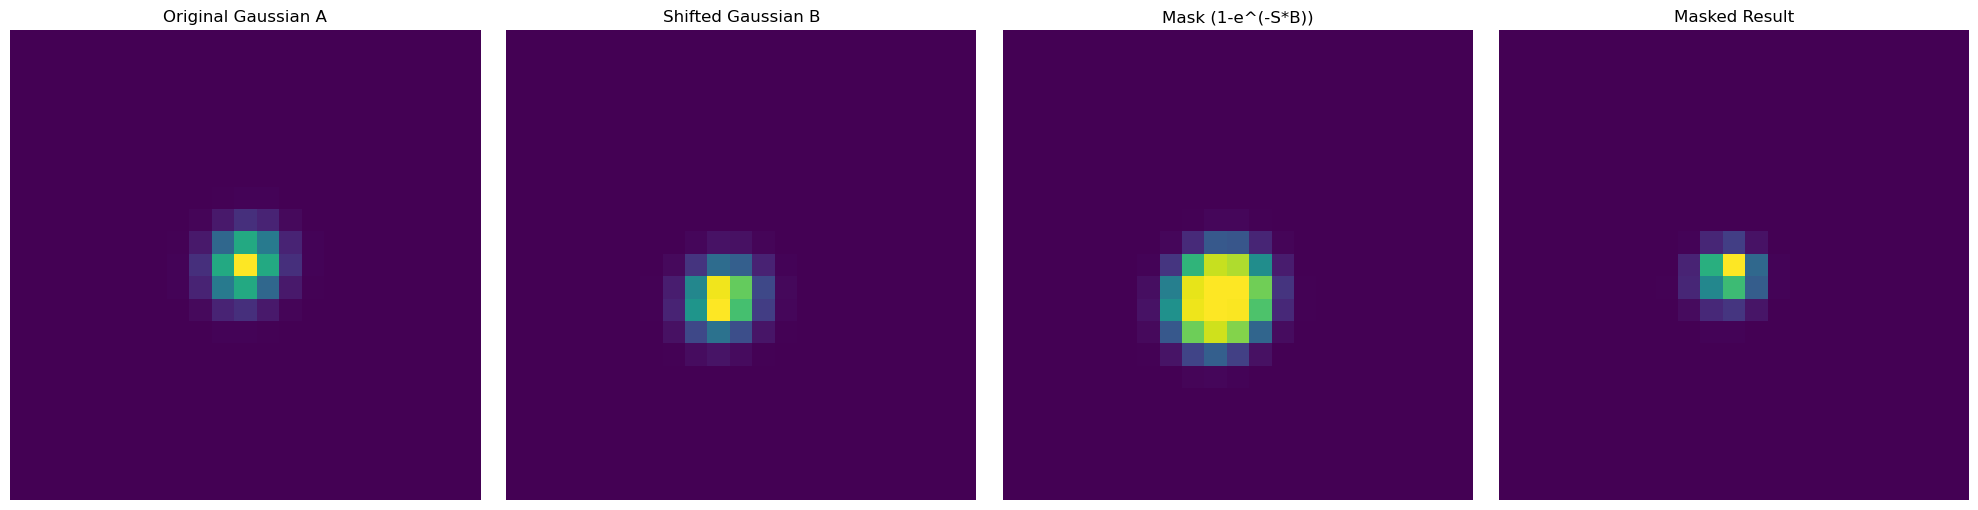

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set up for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class SkewedGaussianSplatting(torch.nn.Module):
    """
    A simplified PyTorch implementation of the skewed Gaussian splatting
    to validate the analytical gradients
    """
    def __init__(self):
        super().__init__()

    def gaussian_2d(self, xy, mean, conic):
        """Compute 2D Gaussian value at xy positions"""
        # xy: [N, 2], mean: [2], conic: [3] (xx, xy, yy)
        d = xy - mean  # [N, 2]
        cxx, cxy, cyy = conic[0], conic[1], conic[2]
        power = -0.5 * (cxx * d[:, 0]**2 + cyy * d[:, 1]**2 + 2 * cxy * d[:, 0] * d[:, 1])
        return torch.exp(power)

    def forward(self, xy, means, skews, conic, opacity, sensitivity):
        """
        Forward pass computing skewed Gaussian values at xy positions
        
        Args:
            xy: pixel positions [N, 2]
            means: center of Gaussian [2]
            skews: skew parameters [2]
            conic: inverse of covariance matrix [3] (xx, xy, yy)
            opacity: base opacity of Gaussian
            sensitivity: skew sensitivity parameter
            
        Returns:
            alpha: final opacity after applying skew mask
        """
        # Compute original Gaussian A
        d = xy - means
        A_raw = self.gaussian_2d(xy, means, conic)
        A = opacity * A_raw
        
        # Compute skewed Gaussian B
        skewed_means = means + skews
        d_tilde = xy - skewed_means
        B_raw = self.gaussian_2d(xy, skewed_means, conic)
        B = opacity * B_raw
        
        # Compute mask
        mask = 1.0 - torch.exp(-sensitivity * B)
        
        # Apply mask and clamp
        h = (A_raw <= 0.99).float()  # Clamping indicator factor
        alpha_raw = torch.minimum(A, torch.tensor(0.99))
        alpha = alpha_raw * mask
        
        return alpha, A, B, mask, d, d_tilde, A_raw, h

def validate_gradients(grid_size=10, pixel_samples=11):
    """
    Validate analytical gradients against PyTorch autograd
    
    Args:
        grid_size: Size of the grid for visualizing results
        pixel_samples: Number of sample pixels for numerical validation
    """
    # Create a model
    model = SkewedGaussianSplatting()
    
    # Generate random parameters (convert to tensors with requires_grad=True)
    means = torch.tensor([grid_size/2, grid_size/2], dtype=torch.float32, requires_grad=True)
    skews = torch.tensor([1.5, -0.8], dtype=torch.float32, requires_grad=True)
    
    # Inverse covariance matrix parameters (conic)
    cxx = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)
    cxy = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)
    cyy = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)
    conic = torch.stack([cxx, cxy, cyy])
    
    opacity = torch.tensor(0.8, dtype=torch.float32, requires_grad=True)
    sensitivity = torch.tensor(10.0, dtype=torch.float32, requires_grad=True)
    
    # Create grid of pixels
    x = torch.linspace(0, grid_size, grid_size+1)
    y = torch.linspace(0, grid_size, grid_size+1)
    X, Y = torch.meshgrid(x, y)
    xy_grid = torch.stack([X.flatten(), Y.flatten()], dim=1)
    
    # Forward pass
    alpha_grid, A_grid, B_grid, mask_grid, d_grid, d_tilde_grid, A_raw_grid, h_grid = model(
        xy_grid, means, skews, conic, opacity, sensitivity
    )
    
    # Plot the results (original Gaussian, skewed Gaussian, and masked result)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(A_grid.detach().reshape(grid_size+1, grid_size+1), cmap='viridis')
    axes[0].set_title('Original Gaussian A')
    
    axes[1].imshow(B_grid.detach().reshape(grid_size+1, grid_size+1), cmap='viridis')
    axes[1].set_title('Shifted Gaussian B')
    
    axes[2].imshow(mask_grid.detach().reshape(grid_size+1, grid_size+1), cmap='viridis')
    axes[2].set_title('Mask (1-e^(-S*B))')
    
    axes[3].imshow(alpha_grid.detach().reshape(grid_size+1, grid_size+1), cmap='viridis')
    axes[3].set_title('Masked Result')
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    
    # Select a subset of pixels for gradient validation
    selected_indices = torch.randint(0, len(xy_grid), (pixel_samples,))
    xy_samples = xy_grid[selected_indices]
    
    # Process these samples
    alpha, A, B, mask, d, d_tilde, A_raw, h = model(xy_samples, means, skews, conic, opacity, sensitivity)
    
    # Define a loss (just sum of alphas for this test)
    loss = alpha.sum()
    
    # Get PyTorch gradients
    loss.backward()
    
    # Now compute analytical gradients for each parameter and compare with PyTorch results
    print("\n==== GRADIENT VALIDATION ====")
    
    # Analytical gradients
    analytical_results = []
    torch_results = []
    
    # ----- Sensitivity (S) -----
    for i in range(len(alpha)):
        # For each pixel
        dL_dalpha = 1.0  # Gradient from sum loss
        
        # Analytical: dL/dS = dL/dalpha * dalpha/dS = dL/dalpha * A * B * (1-mask)
        analytical_dL_dS = dL_dalpha * A[i] * B[i] * (1 - mask[i])
        analytical_results.append(("Sensitivity", i, analytical_dL_dS.item()))
    
    torch_results.append(("Sensitivity", sensitivity.grad.item()))
    
    # ----- Skew parameters (sx, sy) -----
    for i in range(len(alpha)):
        dL_dalpha = 1.0  # Gradient from sum loss
        
        # Extract parameters for this pixel
        cxx_val, cxy_val, cyy_val = conic[0].item(), conic[1].item(), conic[2].item()
        a_val, b_val = A[i].item(), B[i].item()
        s_val = sensitivity.item()
        mask_val = mask[i].item()
        dtilde_x, dtilde_y = d_tilde[i, 0].item(), d_tilde[i, 1].item()
        
        # conic * d_tilde
        conic_dtilde_x = cxx_val * dtilde_x + cxy_val * dtilde_y
        conic_dtilde_y = cxy_val * dtilde_x + cyy_val * dtilde_y
        
        # Analytical: dL/ds = dL/dalpha * dalpha/ds = dL/dalpha * A * S * (1-mask) * B * C * d_tilde
        analytical_dL_dsx = dL_dalpha * a_val * s_val * (1-mask_val) * b_val * conic_dtilde_x
        analytical_dL_dsy = dL_dalpha * a_val * s_val * (1-mask_val) * b_val * conic_dtilde_y
        
        analytical_results.append(("Skew X", i, analytical_dL_dsx))
        analytical_results.append(("Skew Y", i, analytical_dL_dsy))
    
    torch_results.append(("Skew X", skews.grad[0].item()))
    torch_results.append(("Skew Y", skews.grad[1].item()))
    
    # ----- Opacity (o) -----
    for i in range(len(alpha)):
        dL_dalpha = 1.0
        
        A_i = A[i].item()           #  <──  usa A, no A_raw
        B_i = B[i].item()
        h_i = h[i].item()
        m_i = mask[i].item()        #  m = mask
        S_i = sensitivity.item()
        o_i = opacity.item()
        
        analytical_dL_do = ( h_i * m_i * A_i
                        + S_i * (1 - m_i) * A_i * B_i ) / o_i
        analytical_results.append(("Opacity", i, analytical_dL_do))
        
        torch_results.append(("Opacity", opacity.grad.item()))
    
    # ----- Conic parameters (cxx, cxy, cyy) -----
    for i in range(len(alpha)):
        dL_dalpha = 1.0
        
        a_val, b_val = A[i].item(), B[i].item()
        h_val = h[i].item()
        s_val = sensitivity.item()
        mask_val = mask[i].item()
        dx, dy = d[i, 0].item(), d[i, 1].item()
        dtilde_x, dtilde_y = d_tilde[i, 0].item(), d_tilde[i, 1].item()
        
        # q_A and q_B vectors
        q_A = [dx**2, 2*dx*dy, dy**2]
        q_B = [dtilde_x**2, 2*dtilde_x*dtilde_y, dtilde_y**2]
        
        # CORRECTED: Include h factor for clamping
        # Analytical: dL/dc = -0.5 * dL/dalpha * A * [h*m*q_A + S*(1-m)*B*q_B]
        for j, (q_a_val, q_b_val) in enumerate(zip(q_A, q_B)):
            analytical_dL_dc = -0.5 * dL_dalpha * a_val * (h_val * mask_val * q_a_val + s_val * (1-mask_val) * b_val * q_b_val)
            param_name = ["Cxx", "Cxy", "Cyy"][j]
            analytical_results.append((param_name, i, analytical_dL_dc))
    
    torch_results.append(("Cxx", cxx.grad.item()))
    torch_results.append(("Cxy", cxy.grad.item()))
    torch_results.append(("Cyy", cyy.grad.item()))
    
    # ----- Centers (dx, dy) -----
    for i in range(len(alpha)):
        dL_dalpha = 1.0
        
        a_val, b_val = A[i].item(), B[i].item()
        h_val = h[i].item()
        s_val = sensitivity.item()
        mask_val = mask[i].item()
        dx, dy = d[i, 0].item(), d[i, 1].item()
        dtilde_x, dtilde_y = d_tilde[i, 0].item(), d_tilde[i, 1].item()
        
        cxx_val, cxy_val, cyy_val = conic[0].item(), conic[1].item(), conic[2].item()
        
        # C * d
        cd_x = cxx_val * dx + cxy_val * dy
        cd_y = cxy_val * dx + cyy_val * dy
        
        # C * d_tilde
        cdtilde_x = cxx_val * dtilde_x + cxy_val * dtilde_y
        cdtilde_y = cxy_val * dtilde_x + cyy_val * dtilde_y
        
        # CORRECTED: Remove negative sign and include h factor
        # Analytical: dL/dd = dL/dalpha * A * [h*m*C*d + S*(1-m)*B*C*d_tilde]
        analytical_dL_ddx = dL_dalpha * a_val * (h_val * mask_val * cd_x + s_val * (1-mask_val) * b_val * cdtilde_x)
        analytical_dL_ddy = dL_dalpha * a_val * (h_val * mask_val * cd_y + s_val * (1-mask_val) * b_val * cdtilde_y)
        
        analytical_results.append(("Center X", i, analytical_dL_ddx))
        analytical_results.append(("Center Y", i, analytical_dL_ddy))
    
    torch_results.append(("Center X", means.grad[0].item()))
    torch_results.append(("Center Y", means.grad[1].item()))
    
    # Print summary comparisons
    param_to_analytical = {}
    for param_name, idx, value in analytical_results:
        if param_name not in param_to_analytical:
            param_to_analytical[param_name] = []
        param_to_analytical[param_name].append(value)
    
    # Compare the sum of analytical gradients with PyTorch gradients
    print("\nComparison of total gradients:")
    print("=" * 60)
    print(f"{'Parameter':<15} {'Analytical Sum':<20} {'PyTorch':<20} {'Error':<15}")
    print("-" * 60)
    
    for param_name, values in param_to_analytical.items():
        analytical_sum = sum(values)
        torch_grad = next((g for n, g in torch_results if n == param_name), None)
        if torch_grad is not None:
            rel_error = abs(analytical_sum - torch_grad) / (abs(torch_grad) + 1e-10)
            error_str = f"{rel_error:.6f}"
            if rel_error < 0.01:
                error_str += " ✓"
            else:
                error_str += " ✗"
            
            print(f"{param_name:<15} {analytical_sum:<20.6f} {torch_grad:<20.6f} {error_str}")
    
    return fig

# Run validation with more samples for better accuracy
fig = validate_gradients(grid_size=20, pixel_samples=100)